In [1]:
using Graphs, IndexedGraphs, Statistics
using MatrixProductBP, MatrixProductBP.Models
using Plots, LaTeXStrings
using Measurements
import ProgressMeter; ProgressMeter.ijulia_behavior(:clear)

include("../../telegram/notifications.jl");

Precompiling MatrixProductBP
  ✓ MatrixProductBP
  1 dependency successfully precompiled in 12 seconds. 148 already precompiled.


In [2]:
T = 300        # final time
k = 3         # degree
λ = 0.07      # rate of transmission
ρ = 0.1       # rate of recovery
γ = 0.2      # prob. of zero patient
N = 5*10^3;

In [3]:
seed = 0
gg = random_regular_graph(N, k; seed)
g = IndexedGraph(gg)

# adjust probabilities and number of discrete time steps to simulate continuous-time behavior
sis = SIS(g, λ, ρ, T; γ);

## Gillespie

In [4]:
Δtplot = 5e-1
p_gill,_ = continuous_sis_sampler(sis, T, λ, ρ; nsamples = 10^3, sites=1:N,
    Δt=Δtplot, discard_dead_epidemics=false)
m_gill = mean(p_gill);

Progress: 100%|█████████████████████████████████████████| Time: 0:01:11


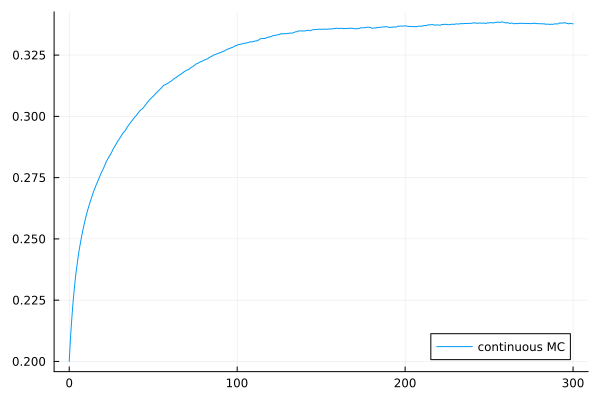

In [5]:
plot(0:Δtplot:T, m_gill, label="continuous MC")

In [19]:
p_ss_cont = mean(m_gill[end-100:end])

0.33795382376237626

## Compare discretization steps

In [12]:
Δts = 10.0 .^ (0:-0.2:-1)
nsamples = 10^3;

In [ ]:
ps = map(eachindex(Δts)) do a
    Δt = Δts[a]
    sis = SIS(g, λ*Δt, ρ*Δt, floor(Int, T/Δt); γ);
    bp = mpbp(sis)
    sms = SoftMarginSampler(bp)
    sample!(sms, nsamples)
    println("Δt=$Δt finished ($a/$(length(Δts)))")
    p = mean([x.val for x in y] for y in means((x, args...)->x-1, sms))
end;

SoftMargin sampling  99%|███████████████████████████████▋|  ETA: 0:00:01SoftMargin sampling   0%|▏                               |  ETA: 4:50:02SoftMargin sampling   0%|▏                               |  ETA: 3:13:10

Δt=1.0 finished (1/6)


Marginals from Soft Margin 100%|█████████████████████████| Time: 0:00:03
SoftMargin sampling  98%|███████████████████████████████▍|  ETA: 0:00:03SoftMargin sampling   0%|▏                               |  ETA: 3:39:20                                                                                          

Δt=0.6309573444801932 finished (2/6)


SoftMargin sampling  98%|███████████████████████████████▎|  ETA: 0:00:08                            %|▏                               |  ETA: 6:51:52SoftMargin sampling   0%|▏                               |  ETA: 6:51:52SoftMargin sampling   0%|▏                               |  ETA: 6:51:52SoftMargin sampling   0%|▏                               |  ETA: 6:51:52SoftMargin sampling   0%|▏                               |  ETA: 6:51:52SoftMargin sampling   0%|▏                               |  ETA: 6:51:52SoftMargin sampling  43%|█████████████▊                  |  ETA: 0:03:30mSoftMargin sampling  73%|███████████████████████▍        |  ETA: 0:01:21

Δt=0.39810717055349726 finished (3/6)


SoftMargin sampling  40%|████████████▊                   |  ETA: 0:12:01m57SoftMargin sampling   0%|▏                               |  ETA: 1 days, 2:29:57

In [ ]:
Δts2 = 10.0 .^ (-1:-0.2:-1.6)
ps2 = map(eachindex(Δts2)) do a
    Δt = Δts2[a]
    sis = SIS(g, λ*Δt, ρ*Δt, floor(Int, T/Δt); γ);
    bp = mpbp(sis)
    sms = SoftMarginSampler(bp)
    sample!(sms, nsamples)
    println("Δt=$Δt finished ($a/$(length(Δts2)))")
    p = mean([x.val for x in y] for y in means((x, args...)->x-1, sms))
end;

base64 binary data: AAAAAAAAAAD//////////wAAAAAAAAAAAAAAAAB/AAAAAAAAAAAAAP//////////AAAAAP5/AAAAAAAAAH8AAAMAAAAAAAAAAAAAAAAAAAAAAPaL/n8AAAAAAAAA9tcrAAAAAAAAAAD//////////wAA9ov+fwAAAAAAAAB/AAAAAAAAAAAAAP//////////                    |  ETA: 1:34:38SoftMargin sampling  33%|██████████▍                     |  ETA: 0:46:46
SoftMargin sampling  98%|███████████████████████████████▍|  ETA: 0:00:39SoftMargin sampling  98%|███████████████████████████████▍|  ETA: 0:00:37 

Δt=0.1 finished (1/4)


Marginals from Soft Margin 100%|█████████████████████████| Time: 0:01:39


In [ ]:
Δts3 = Δts
ps3 = ps;

In [ ]:
Δts = vcat(Δts3, Δts2)
ps = vcat(ps3, ps2);

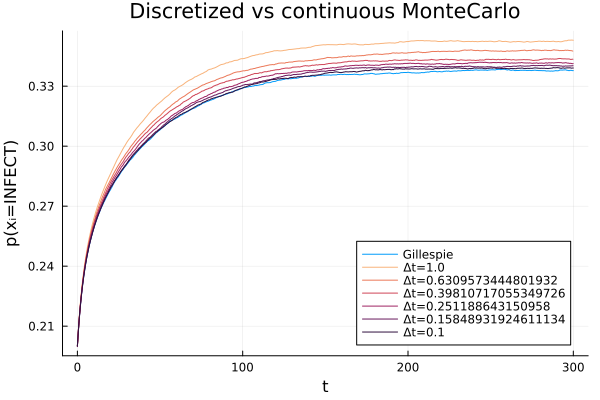

In [17]:
using ColorSchemes
cg = cgrad(:matter, length(Δts)+1, categorical=true)
pl = plot(; xlabel="t", ylabel="p(xᵢ=INFECT)", title="Discretized vs continuous MonteCarlo")
plot!(pl, 0:Δtplot:T, m_gill, label="Gillespie")
for a in eachindex(Δts)
    Δt = Δts[a]
    p = ps[a]
    plot!(pl, 0:Δt:T, p, label="Δt=$Δt", c=cg[a+1]) 
end
pl

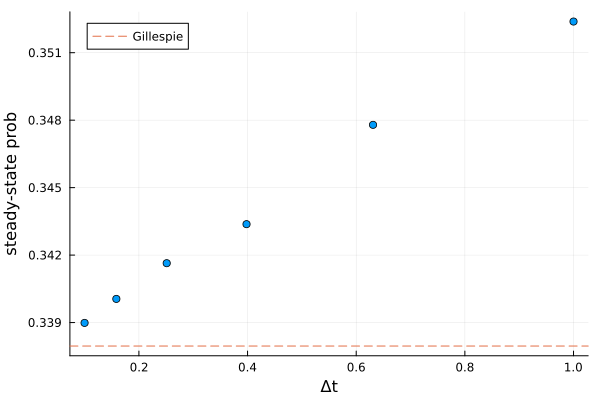

In [21]:
ps_ss = [mean(p[end-floor(Int, 50/Δt):end]) for (p,Δt) in zip(ps,Δts)]
scatter(Δts, ps_ss, xlabel="Δt", ylabel="steady-state prob", label="")
hline!([p_ss_cont], ls=:dash, label="Gillespie")

In [ ]:
@telegram "sis_montecarlo"